In [23]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import pandas as pd

import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

In [24]:
folder = "../build/"
all_folders = glob.glob(os.path.join(folder, "fbmc_*/"))
all_folders.sort(key=os.path.getmtime, reverse=True)
print("Recent simulation folders:")
for f in all_folders[:5]:
    print(f)


Recent simulation folders:
../build/fbmc_Si_300.0_50000/


In [ ]:
def fermi_dirac(E, Ef=0.562161, T=300):
    kB = 8.617333262145e-5  # eV/K
    return 1.0 / (np.exp((E - Ef) / (kB * T)) + 1.0)

Number of files found: 10


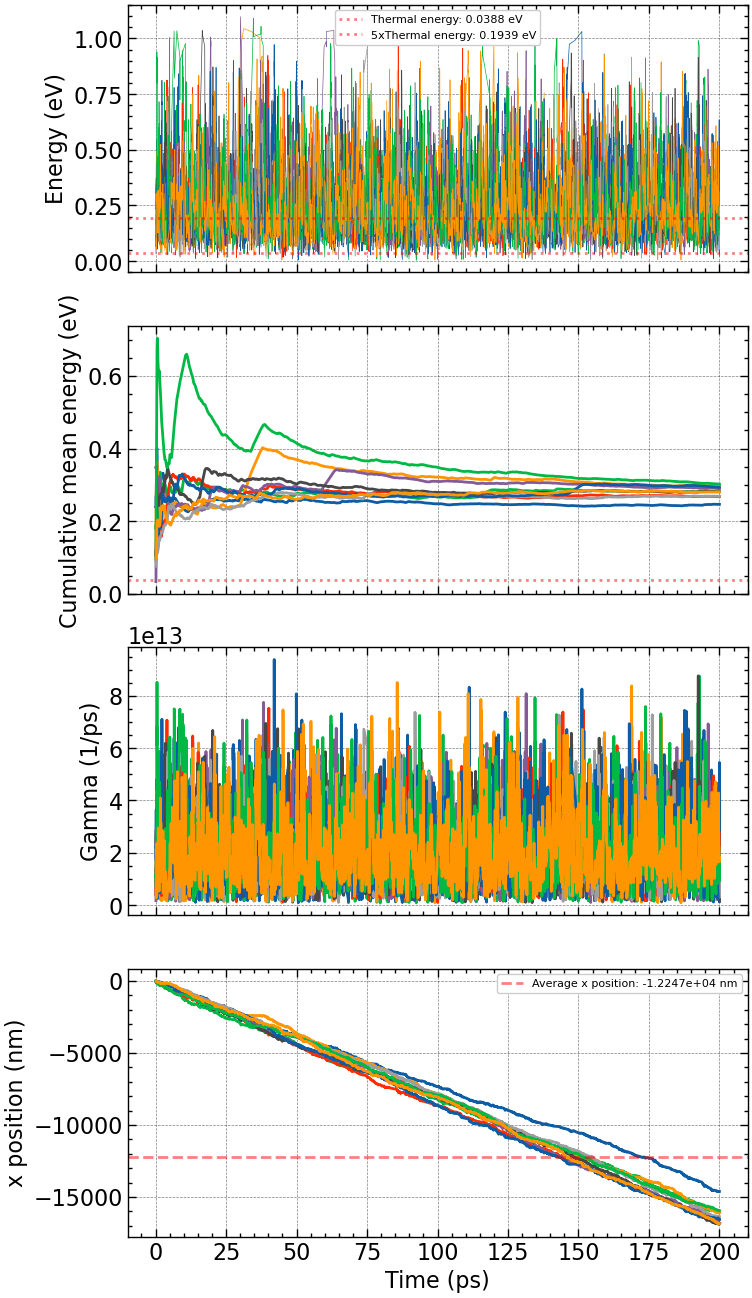

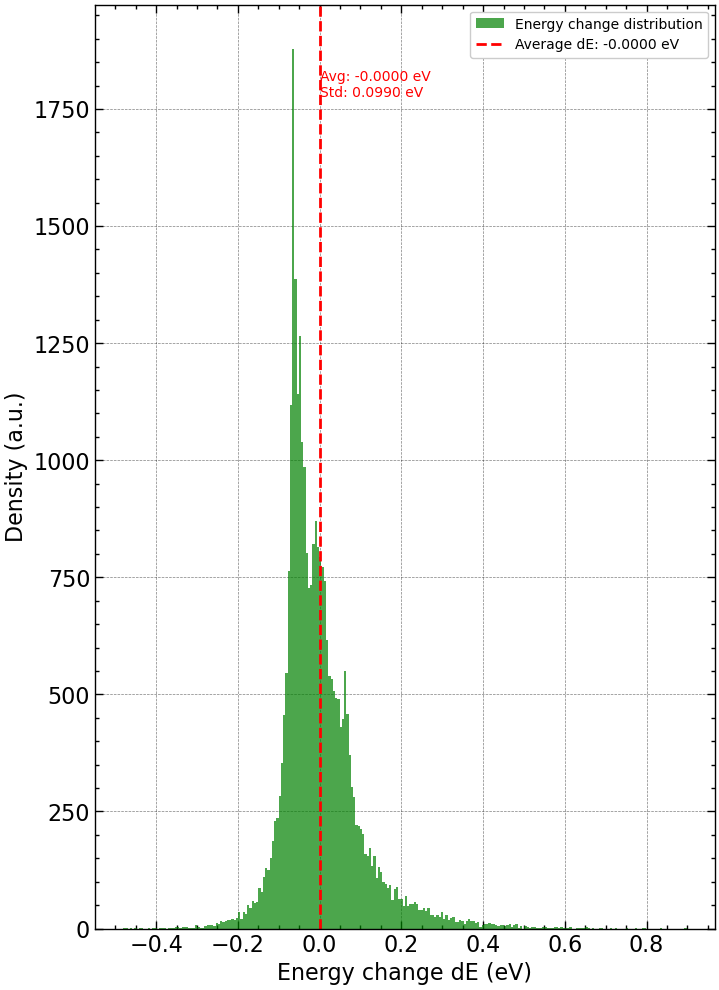

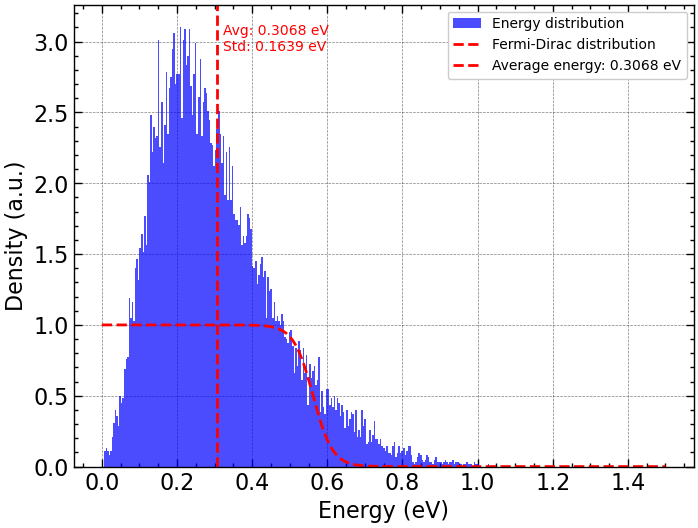

In [28]:
kB = 8.617333262145e-5  # eV/K
T = 300  # K
thermal_energy = (3.0/2.0) * kB * T


for folder in all_folders[:1]:

    all_files = glob.glob(os.path.join(folder, "simulation_result*.csv"))
    # sort files by modification time
    all_files.sort(key=os.path.getmtime, reverse=True)
    print(f"Number of files found: {len(all_files)}")
    fig, ax = plt.subplots(4, sharex=True, figsize=(8, 16))
    NbFilesToPlot = 10000
    NbFilesToPlot = min(NbFilesToPlot, len(all_files))
    all_energies = np.array([])
    all_x_pos = np.array([])
    all_gammas = np.array([])
    all_dE = np.array([])
    for file in all_files[:NbFilesToPlot]:
        data = np.loadtxt(file, delimiter=',', skiprows=1)
        time = 1e12 * data[:, 0]
        nb_cols = data.shape[1]
        energy_data = data[:, nb_cols - 2]
        gamma_data = data[:, 1]
        # Cumulative mean energy weighted by time steps
        cum_mean = np.cumsum(energy_data * np.diff(np.concatenate(([0], time)))) / time
        x_pos = data[:, 2] * 1e9  # in nm
        ax[0].plot(time, energy_data, lw=0.5)
        ax[1].plot(time, cum_mean)
        ax[2].plot(time, gamma_data)
        ax[3].plot(time, x_pos)
        final_mean = cum_mean[-1]
        size_energy = energy_data.shape[0]
        all_energies = np.concatenate((all_energies, energy_data[size_energy//2:]), axis=0)
        all_gammas = np.concatenate((all_gammas, gamma_data[size_energy//2:]), axis=0)
        all_x_pos = np.concatenate((all_x_pos, x_pos[size_energy//2:]), axis=0)
        dEs = np.diff(energy_data)
        dEs = dEs[np.abs(dEs) > 0]
        all_dE = np.concatenate((all_dE, dEs[1:]), axis=0)
    ax[0].set_ylabel("Energy (eV)")
    # ax[0].set_xlim(-1, 10)
    # ax[0].set_ylim(-1e-3, 0.25)

    ax[0].axhline(thermal_energy, color='r', linestyle=':', label=f'Thermal energy: {thermal_energy:.4f} eV', alpha=0.5)
    ax[0].axhline(5*thermal_energy, color='r', linestyle=':', label=f'5xThermal energy: {5*thermal_energy:.4f} eV', alpha=0.5)
    ax[1].axhline(thermal_energy, color='r', linestyle=':', label=f'Thermal energy: {thermal_energy:.4f} eV', alpha=0.5)
    mean_x_pos = np.mean(all_x_pos)
    ax[3].axhline(mean_x_pos, color='r', linestyle='--', label=f'Average x position: {mean_x_pos:.4e} nm', alpha=0.5)
    ax[3].set_xlabel("Time (ps)")
    ax[1].set_ylabel("Cumulative mean energy (eV)")
    ax[2].set_ylabel("Gamma (1/ps)")
    ax[3].set_ylabel("x position (nm)")
    ax[0].legend(fontsize=8)
    ax[3].legend(fontsize=8)

    # Plot dE
    figg, ax = plt.subplots(1, sharex=True, figsize=(8, 12))
    ax.hist(all_dE, bins=250, density=False, alpha=0.7, color='g', label='Energy change distribution')
    avg_dE = np.mean(all_dE)
    std_dE = np.std(all_dE)
    ax.axvline(avg_dE, color='r', linestyle='--', label=f'Average dE: {avg_dE:.4f} eV')
    ax.text(avg_dE + 0.05*avg_dE, ax.get_ylim()[1]*0.9, f'Avg: {avg_dE:.4f} eV\nStd: {std_dE:.4f} eV', color='r')
    ax.legend(fontsize=10)
    # ax.set_xlim(-0.07, 0.07)
    ax.set_xlabel("Energy change dE (eV)")
    ax.set_ylabel("Density (a.u.)")
    plt.show()
        

    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.hist(all_energies, bins=250, density=True, alpha=0.7, color='b', label='Energy distribution')
    avg_energy = np.mean(all_energies)
    std_energy = np.std(all_energies)
    e_lin = np.linspace(0, 1.5, 500)
    fermi_dist = fermi_dirac(e_lin, Ef=0.562161, T=300)
    ax.plot(e_lin, fermi_dist, 'r--', lw=2, label='Fermi-Dirac distribution')

    ax.axvline(avg_energy, color='r', linestyle='--', label=f'Average energy: {avg_energy:.4f} eV')
    ax.text(avg_energy + 0.05*avg_energy, ax.get_ylim()[1]*0.9, f'Avg: {avg_energy:.4f} eV\nStd: {std_energy:.4f} eV', color='r')
    ax.legend(fontsize=10)
    ax.set_xlabel("Energy (eV)")
    ax.set_ylabel("Density (a.u.)")
    plt.show()



    # argmaxDE = np.argmax(np.abs(all_dE))
    # print(f"Largest energy change dE: {all_dE[argmaxDE]:.4f} eV")
    # print(f"Corresponding gamma before change: {all_gammas[argmaxDE]:.4f}")

In [27]:
file_phononss = glob.glob(os.path.join(folder, "*eph*.msh"))
print(file_phononss)
data_phonons = np.loadtxt(file_phononss[0], delimiter=',', skiprows=1)
NbCols = data_phonons.shape[1]
# vtx, band, energy, rates...
energies_ph = data_phonons[:, 2]
total_rates_ph = np.sum(data_phonons[:, 3:NbCols], axis=1)
fig, ax = plt.subplots(1, figsize=(8, 6))

ene_fbmc = energy_data
gamma_fbmc = gamma_data

ax.scatter(ene_fbmc, gamma_fbmc, s=1, c='r', label='FBMC data')
ax.scatter(energies_ph, total_rates_ph, s=1, c='b', label='Phonon data')
# for idx in range(0, 8):
#     rates_ph = data_phonons[:, 3 + idx]
#     ax.scatter(energies_ph, rates_ph, s=1)
ax.set_xlabel("Phonon Energy (eV)")
ax.set_ylabel("Total Scattering rate (1/s)")
ax.legend(fontsize=10, loc='upper right')
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 0.2e14)
plt.show()

[]


IndexError: list index out of range

In [ ]:
file_phononss = glob.glob(os.path.join(folder, "*eph*.msh"))
print(file_phononss)
data_phonons = np.loadtxt(file_phononss[0], delimiter=',', skiprows=1)
NbCols = data_phonons.shape[1]
# vtx, band, energy, rates...
energies_ph = data_phonons[:, 2]
total_rates_ph = np.sum(data_phonons[:, 3:NbCols], axis=1)



file_gammas = folder + "eelph_test_output.txt"
data_gammas = np.loadtxt(file_gammas, delimiter=',', skiprows=1)
energies_gammas = data_gammas[:, 0]
rates_gammas = data_gammas[:, 1:]
sum_rates_gammas = np.sum(rates_gammas, axis=1)

file_fin = f"{folder}fbmc_debug_log.txt"
data_fbmc = pd.read_csv(file_fin, names=["energy", "sum_rates", "Gamma"])
energies_fbmc = data_fbmc["energy"].to_numpy()
sum_rates_fbmc = data_fbmc["sum_rates"].to_numpy()
gammas_fbmc = data_fbmc["Gamma"].to_numpy()



fig, ax = plt.subplots(1, figsize=(8, 6))
ax.scatter(energies_gammas, sum_rates_gammas, s=5, c='k',marker='>', label='Electron data')
ax.scatter(all_energies, all_gammas, s=5, c='k',marker='>', label='Electron data')
ax.scatter(energies_ph, total_rates_ph, s=1, c='b', label='Phonon data')
ax.scatter(energies_fbmc, sum_rates_fbmc, s=5, c='r', marker='x', label='FBMC sum rates')
ax.scatter(energies_fbmc, gammas_fbmc, s=5, c='g', marker='o', label='FBMC Gamma')

# for idx in range(0, 8):
#     rates_ph = data_phonons[:, 3 + idx]
#     ax.scatter(energies_ph, rates_ph, s=1)
ax.set_xlabel("Phonon Energy (eV)")
ax.set_ylabel("Total Scattering rate (1/s)")
ax.legend(fontsize=10, loc='upper right')
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 0.2e14)
plt.show()

[]


IndexError: list index out of range

Phonon dispersion files found: ['../build/optical_longitudinal_dispersion.csv', '../build/acoustic_transverse_dispersion.csv', '../build/acoustic_longitudinal_dispersion.csv', '../build/optical_transverse_dispersion.csv']


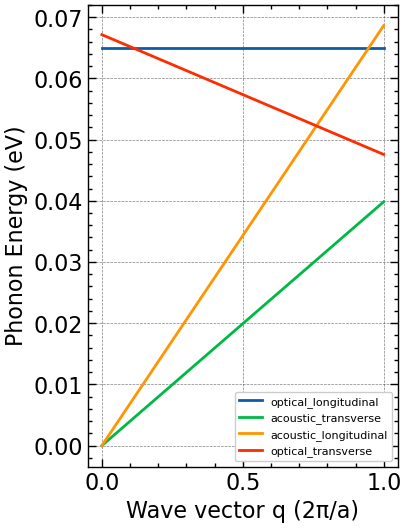

In [ ]:
folder = "../build/"
files = glob.glob(os.path.join(folder, "*_dispersion.csv"))
print("Phonon dispersion files found:", files)
fig, ax = plt.subplots(1, figsize=(4, 6))
for f in files:
    q, omega, energy = np.loadtxt(f, delimiter=',', unpack=True, skiprows=1)

    a = 5.43e-10  # m
    fact = 2 * np.pi / a
    q_scaled = q / fact
    ax.plot(q_scaled, energy, label=os.path.basename(f).replace("_dispersion.csv",""))
# ax.set_xlim(0, 1)
ax.set_xlabel("Wave vector q (2π/a)")
ax.set_ylabel("Phonon Energy (eV)")
ax.legend(fontsize=8)
plt.show()